# Tutorial 1: Kernel1D

In [1]:
import matplotlib.pyplot as plt
import torch
from spectpsftoolbox.kernel1d import FunctionKernel1D, ArbitraryKernel1D
from spectpsftoolbox.operator2d import GaussianOperator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1D kernels in `spectpsftoolbox` can be expressed as 

$$f(x,a) = A(a,\vec{b}) \cdot k\left(\frac{x}{\sigma(a,\vec{b})}\right)$$

 where $x$ is position and $a$ is some scalar that the kernel depends on, and $\vec{b}$ are additional hyperparameters. The amplitude $A(a)$ and scaling $\sigma(a)$ may also depend on additional parameters. We start be defining them:

 * $A(a,\vec{b}) = b_0 e^{-b_1a}$
 * $\sigma(a,\vec{b}) = b_0(a+0.1)$

In [2]:
amplitude_fn = lambda a, bs: bs[0]*torch.exp(-bs[1]*a)
sigma_fn = lambda a, bs: bs[0]*(a+0.1)

Now we define the initial parameters $\vec{b}$ they are expected to be torch tensors:
* In the code below, we initialize $b_0=2$ and $b_1=0.1$ for $A(a,\vec{b})$

In [3]:
amplitude_params = torch.tensor([2,0.1], device=device, dtype=torch.float32)
sigma_params = torch.tensor([0.3], device=device, dtype=torch.float32)

# Function Kernel

For function kernels, $k(x)$ is set explicitly. Let's set $k(x) = e^{-|x|}$

In [4]:
kernel_fn = lambda x: torch.exp(-torch.abs(x))

Now we can build the function kernel:

In [6]:
kernel1D = FunctionKernel1D(kernel_fn, amplitude_fn, sigma_fn, amplitude_params, sigma_params)

Lets look at the value of the kernel at various values of $a$:

In [7]:
x = torch.linspace(-5,5,100).to(device)
a = torch.linspace(1,10,5).to(device)

kernel_value = kernel1D(x, a)

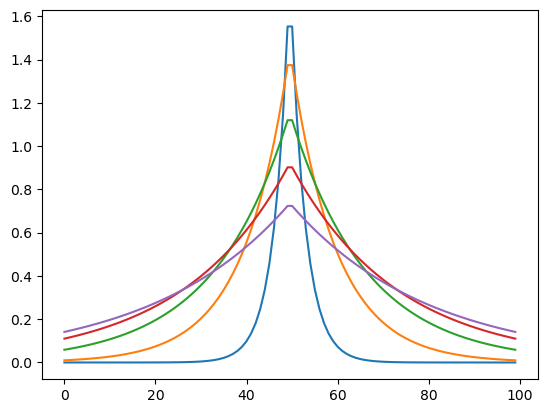

In [8]:
plt.plot(kernel_value.cpu().T)
plt.show()

We can also get normalized values:

tensor([0.9961, 0.9930, 0.9504, 0.8828, 0.8111], device='cuda:0')


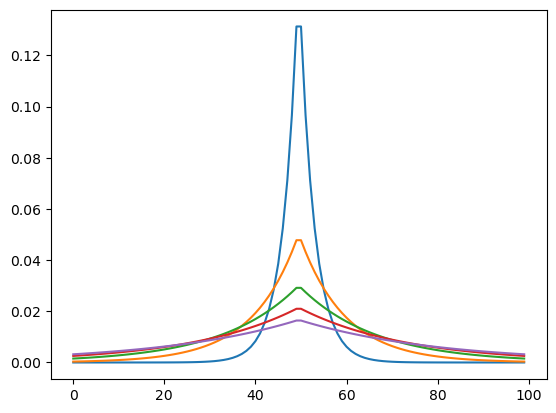

In [9]:
kernel_value = kernel1D(x, a, normalize=True)
print(kernel_value.sum(dim=1))
plt.plot(kernel_value.cpu().T)
plt.show()

# Arbitrary Kernels

We can also define arbitrary kernels that have no explicit functional form given some data. For suppose the below was data we collected:

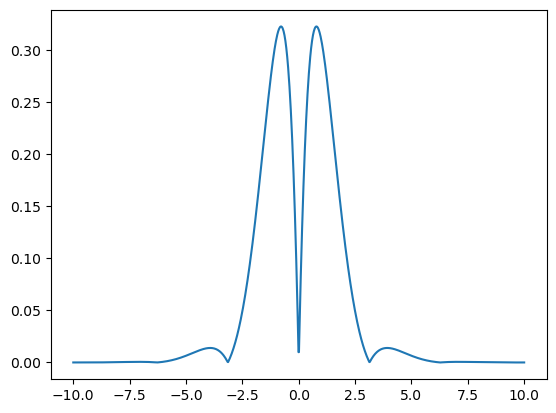

In [10]:
x = torch.linspace(-10,10,1000).to(device)
k_data = torch.exp(-torch.abs(x))*torch.abs(torch.sin(x))
plt.plot(x.cpu(),k_data.cpu())

Then we can define an arbitrary kernel:

In [11]:
arb_kernel1D = ArbitraryKernel1D(
    kernel=k_data,
    amplitude_fn=amplitude_fn,
    sigma_fn=sigma_fn,
    amplitude_params=amplitude_params,
    sigma_params=sigma_params,
    dx0 = x[1]-x[0] # needs to be provided
)

Lets define some new positions different from the above and evaluate the kernel:

In [12]:
x = torch.linspace(-9,9,500).to(device)
a = torch.linspace(1,10,5).to(device)
kernel_value = arb_kernel1D(x, a)

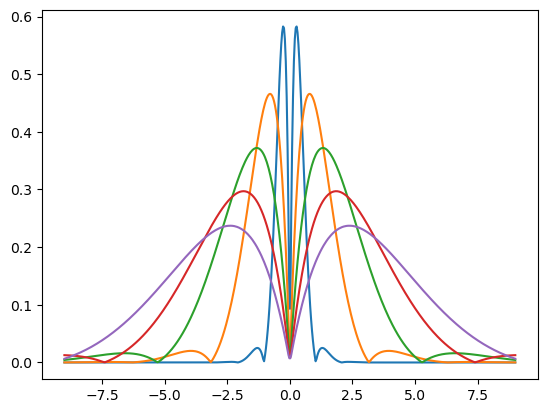

In [13]:
plt.plot(x.cpu(), kernel_value.cpu().T)
plt.show()

We can also get normalized values (each sums to 1)

* Some of the more stretched ones don't sum to 1 because they have non-zero values outside the field of view

tensor([1.0008, 1.0000, 0.9956, 0.9684, 0.9556], device='cuda:0')


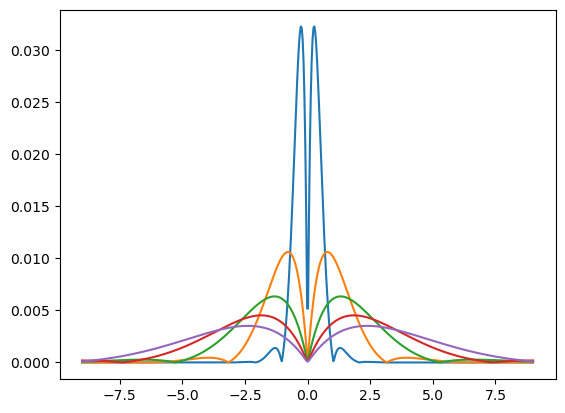

In [14]:
kernel_value = arb_kernel1D(x, a, normalize=True)
print(kernel_value.sum(dim=1))
plt.plot(x.cpu(), kernel_value.cpu().T)
plt.show()